In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns; sns.set() # sns.set() ==> グラフの見た目をseabornに合わせる

In [2]:
train_df = pd.read_csv('/home/masa/masa/feedback-prize-english-language-learning/workspace/maruyama/data/train.csv')
test_df = pd.read_csv('/home/masa/masa/feedback-prize-english-language-learning/workspace/maruyama/data/test.csv')

In [3]:
train_df['full_text_pre'] = train_df['full_text'].str.replace('\n', '')
train_df['full_text_pre'] = train_df['full_text_pre'].str.replace('\r', '')
train_df['full_text_pre'] = train_df['full_text_pre'].str.replace('.', ' ')
train_df['full_text_pre'] = train_df['full_text_pre'].str.replace(',', ' ')
train_df['full_text_pre'] = train_df['full_text_pre'].str.replace('!', '')
train_df['full_text_pre'] = train_df['full_text_pre'].str.replace('?', '')
train_df['full_text_pre'] = train_df['full_text_pre'].str.replace('"', '')
train_df['full_text_pre'] = train_df['full_text_pre'].str.replace(':', '')
train_df['full_text_pre'] = train_df['full_text_pre'].str.replace(';', '')
train_df['full_text_pre'] = train_df['full_text_pre'].str.replace('\d+', '')
train_df['full_text_pre'] = train_df['full_text_pre'].str.replace('  ', ' ')
train_df['full_text_pre'] = train_df['full_text_pre'].astype(str)

language_tool_pythonの利用

In [4]:
import language_tool_python

In [5]:
tool = language_tool_python.LanguageTool('en-US')
text = 'A sentence with a error in the Hitchhiker’s Guide tot he Galaxy'
matches = tool.check(text)
matches

[Match({'ruleId': 'EN_A_VS_AN', 'message': 'Use “an” instead of ‘a’ if the following word starts with a vowel sound, e.g. ‘an article’, ‘an hour’.', 'replacements': ['an'], 'offsetInContext': 16, 'context': 'A sentence with a error in the Hitchhiker’s Guide tot he ...', 'offset': 16, 'errorLength': 1, 'category': 'MISC', 'ruleIssueType': 'misspelling', 'sentence': "A sentence with a error in the Hitchhiker's Guide tot he Galaxy"}),
 Match({'ruleId': 'TOT_HE', 'message': 'Did you mean “to the”?', 'replacements': ['to the'], 'offsetInContext': 43, 'context': '... with a error in the Hitchhiker’s Guide tot he Galaxy', 'offset': 50, 'errorLength': 6, 'category': 'TYPOS', 'ruleIssueType': 'misspelling', 'sentence': "A sentence with a error in the Hitchhiker's Guide tot he Galaxy"})]

In [6]:
mistake = []
mistake.append(matches)

In [7]:
mistake_l =[item for sublist in [[mistake[i][j].ruleIssueType for j in range(len(mistake[i]))]  for i in range(len(mistake))] for item in sublist]

In [8]:
set(mistake_l)

{'misspelling'}

In [9]:
def get_mistakes(df):
    tool = language_tool_python.LanguageTool('en-US')
    mistakes = []
    for text in df['full_text_pre'].values:
        mistakes.append(tool.check(text))
    return mistakes

In [10]:
mistakes = get_mistakes(train_df)

In [11]:
def get_unique_list(mistakes): #not for submission
    mistake_list = [item for sublist in [[mistakes[i][j].ruleIssueType for j in range(len(mistakes[i]))]  for i in range(len(mistakes))] for item in sublist]
    mistakes_unique = [ item for item in set(mistake_list)]
    mistakes_unique.remove('grammar') #name equals that of a target column
    mistakes_unique.append('grammar_mistakes')
    return mistakes_unique

In [12]:
mistakes_unique = get_unique_list(mistakes) 

In [13]:
mistakes_unique

['inconsistency',
 'whitespace',
 'misspelling',
 'typographical',
 'uncategorized',
 'style',
 'duplication',
 'locale-violation',
 'grammar_mistakes']

In [14]:
def get_features(mistakes, mistakes_unique, df):
    for a in mistakes_unique:
        df[a] = 0
    df['error_length'] = 0
    idx = 0
    for item in mistakes:
        if len(item) > 0:
            for i in range(len(item)):
                if item[i].ruleIssueType == 'grammar':
                    df.iloc[idx, df.columns.get_loc('grammar_mistakes')] += 1
                elif item[i].ruleIssueType in mistakes_unique and item[i].ruleIssueType != 'grammar':
                    df.iloc[idx, df.columns.get_loc(item[i].ruleIssueType)] += 1
                df.iloc[idx, df.columns.get_loc('error_length')] += item[i].errorLength
        idx +=1
    df['sum_mistakes'] = df[mistakes_unique].sum(axis=1)
    return df

In [15]:
train_df = get_features(mistakes, mistakes_unique, train_df)

In [16]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,full_text_pre,inconsistency,whitespace,misspelling,typographical,uncategorized,style,duplication,locale-violation,grammar_mistakes,error_length,sum_mistakes
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,I think that students would benefit from learn...,0,1,8,2,0,0,0,0,2,58,13
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,When a problem is a change you have to let it ...,0,0,25,5,0,2,0,0,8,145,40
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,Dear PrincipalIf u change the school policy of...,0,0,7,2,0,0,0,0,1,56,10
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,The best time in life is when you become yours...,0,0,3,11,0,1,0,0,1,76,16
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,Small act of kindness can impact in other peop...,0,1,13,2,0,0,0,0,2,170,18


In [17]:
mistake_features = mistakes_unique + ['error_length'] + ['sum_mistakes']
display(train_df[mistake_features])

,inconsistency,whitespace,misspelling,typographical,uncategorized,style,duplication,locale-violation,grammar_mistakes,error_length,sum_mistakes
0,0,1,8,2,0,0,0,0,2,58,13
1,0,0,25,5,0,2,0,0,8,145,40
2,0,0,7,2,0,0,0,0,1,56,10
3,0,0,3,11,0,1,0,0,1,76,16
4,0,1,13,2,0,0,0,0,2,170,18
...,...,...,...,...,...,...,...,...,...,...,...
3906,0,0,17,2,0,1,0,0,0,104,20
3907,0,0,20,0,0,0,1,0,2,181,23
3908,0,0,14,1,0,0,0,0,1,89,16
3909,0,0,2,4,0,0,0,0,0,53,6


In [18]:
mistake_features

['inconsistency',
 'whitespace',
 'misspelling',
 'typographical',
 'uncategorized',
 'style',
 'duplication',
 'locale-violation',
 'grammar_mistakes',
 'error_length',
 'sum_mistakes']

In [19]:
for col in mistake_features:
    print(col)

inconsistency
whitespace
misspelling
typographical
uncategorized
style
duplication
locale-violation
grammar_mistakes
error_length
sum_mistakes


In [20]:
def get_proportions(df):
    for col in mistake_features:
        df[col]= df[col]/df['full_text'].apply(len)*1000
    return df


train_df = get_proportions(train_df)

In [22]:
train_df.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions', 'full_text_pre',
       'inconsistency', 'whitespace', 'misspelling', 'typographical',
       'uncategorized', 'style', 'duplication', 'locale-violation',
       'grammar_mistakes', 'error_length', 'sum_mistakes'],
      dtype='object')

In [23]:
display(train_df[mistake_features])

,inconsistency,whitespace,misspelling,typographical,uncategorized,style,duplication,locale-violation,grammar_mistakes,error_length,sum_mistakes
0,0.0,0.720981,5.767844,1.441961,0.0,0.000000,0.000000,0.0,1.441961,41.816871,9.372747
1,0.0,0.000000,9.487666,1.897533,0.0,0.759013,0.000000,0.0,3.036053,55.028463,15.180266
2,0.0,0.000000,4.209260,1.202646,0.0,0.000000,0.000000,0.0,0.601323,33.674083,6.013229
3,0.0,0.000000,0.755097,2.768689,0.0,0.251699,0.000000,0.0,0.251699,19.129122,4.027183
4,0.0,0.754148,9.803922,1.508296,0.0,0.000000,0.000000,0.0,1.508296,128.205128,13.574661
...,...,...,...,...,...,...,...,...,...,...,...
3906,0.0,0.000000,17.400205,2.047083,0.0,1.023541,0.000000,0.0,0.000000,106.448311,20.470829
3907,0.0,0.000000,7.683442,0.000000,0.0,0.000000,0.384172,0.0,0.768344,69.535152,8.835959
3908,0.0,0.000000,10.785824,0.770416,0.0,0.000000,0.000000,0.0,0.770416,68.567026,12.326656
3909,0.0,0.000000,0.705965,1.411931,0.0,0.000000,0.000000,0.0,0.000000,18.708083,2.117896


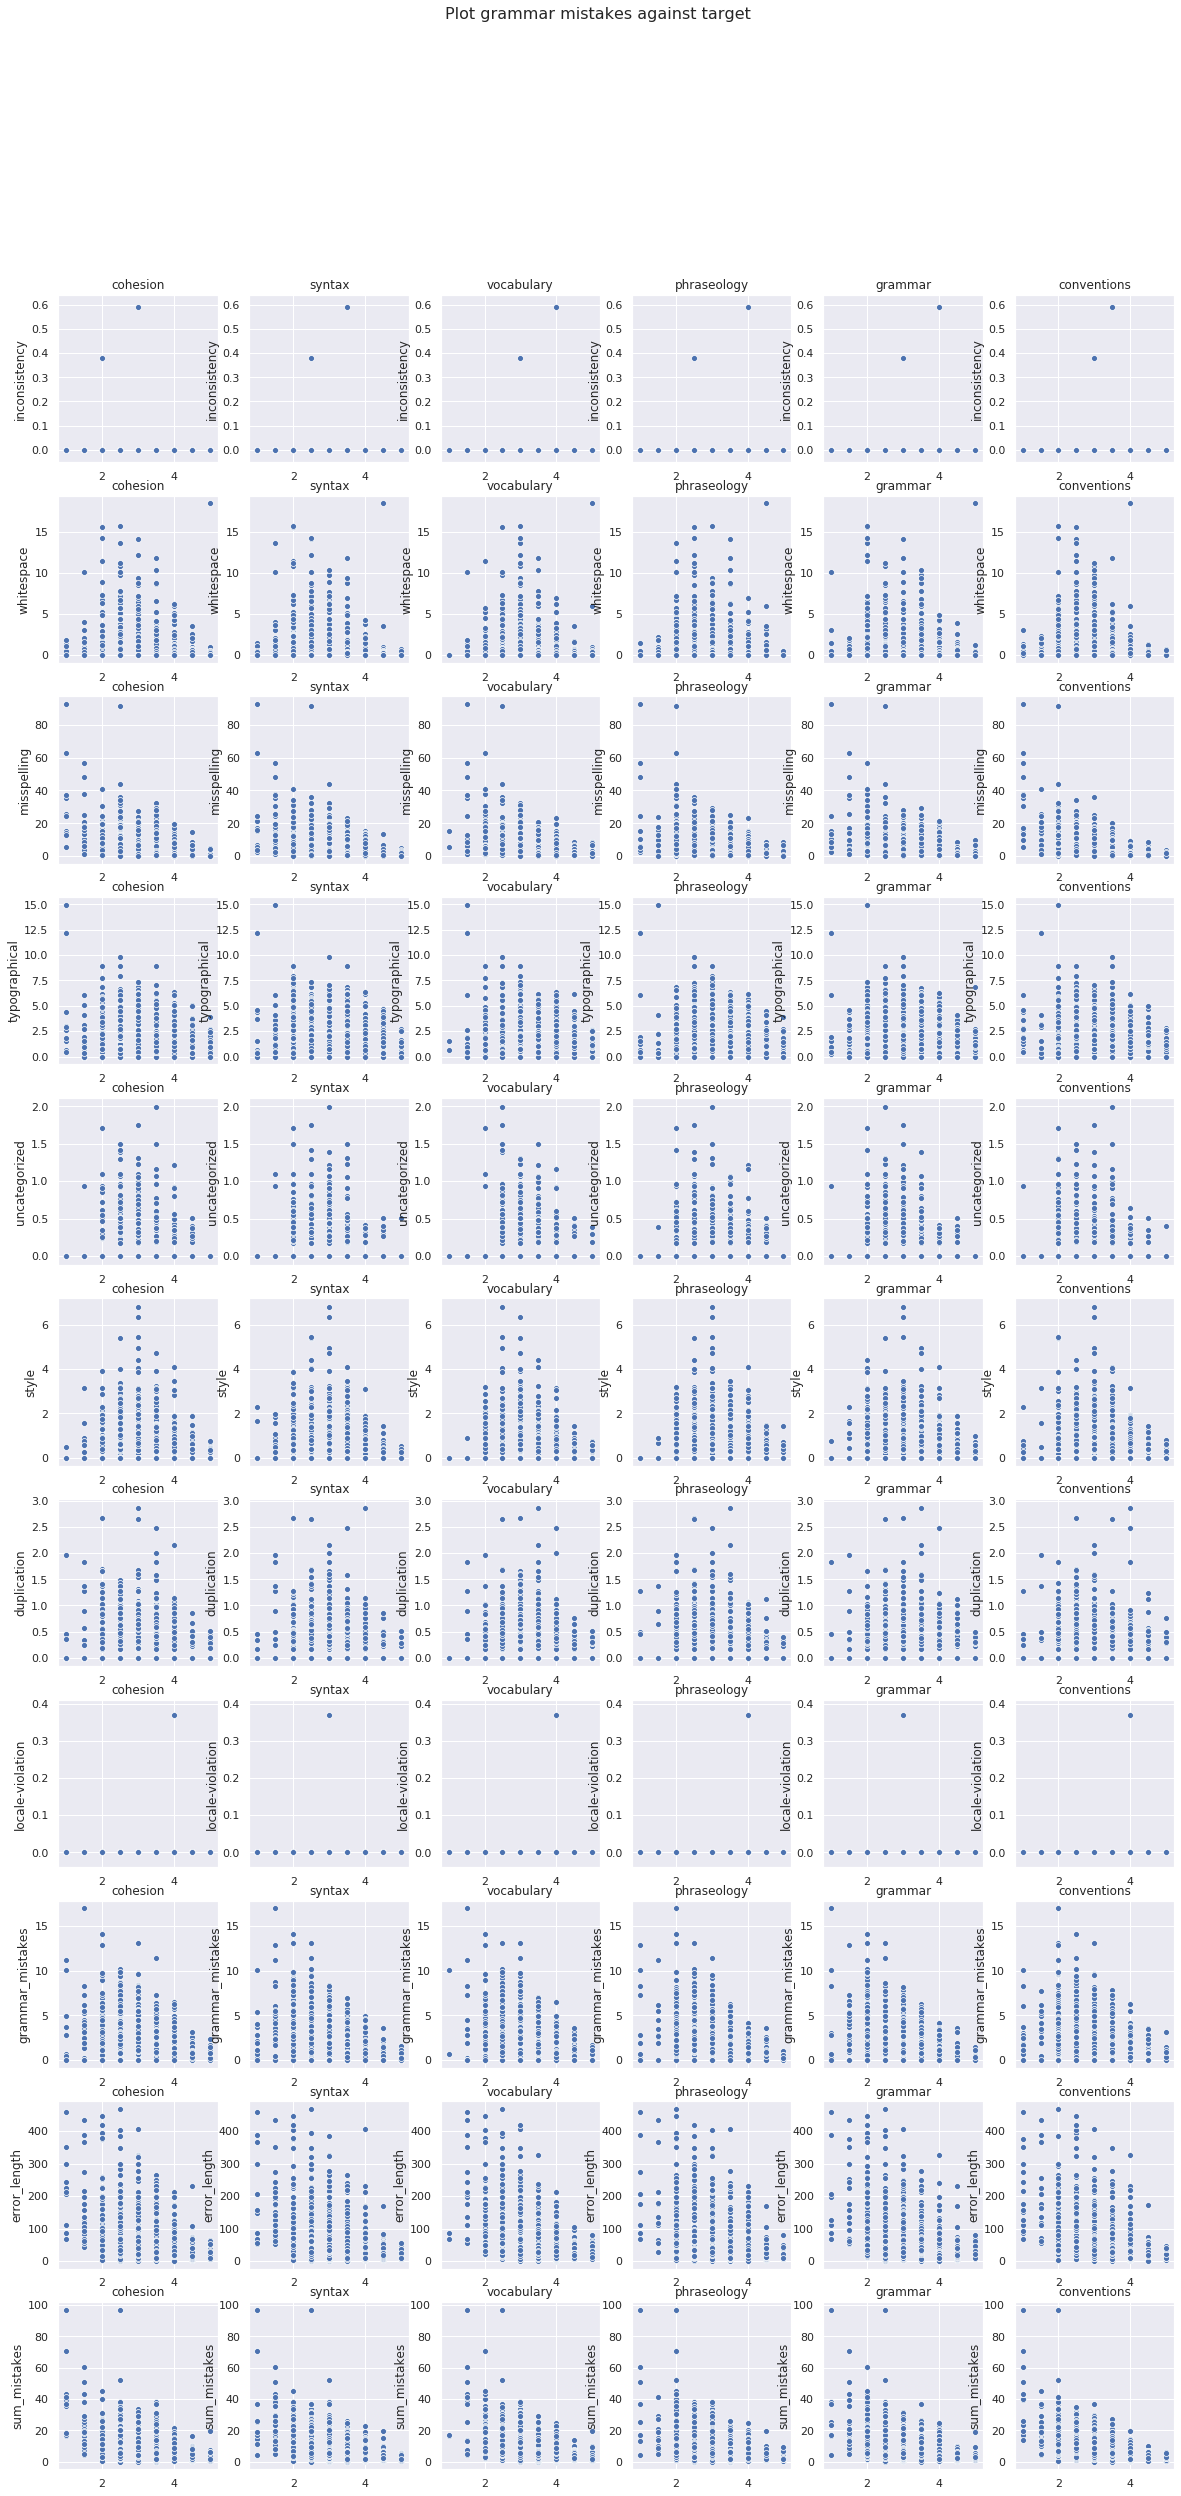

In [24]:
TARGET_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
fig, ax = plt.subplots(11,6, figsize=(20,40))
fig.suptitle('Plot grammar mistakes against target',fontsize=16)
#row=0
col=[0,1,2,3,4,5]*11

for row, feature in enumerate(mistake_features):
    for i, column in enumerate(TARGET_COLS):
        #if (i!=0)&(i%6==0):
        #    row+=1
        sns.scatterplot(x=column, y= mistake_features[row], data=train_df, 
                     legend=False, ax=ax[row,col[i]])
        ax[row,col[i]].tick_params(left=False,bottom=False)
        #ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=(feature if i%5==0 else ''))
        ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=feature)# if i%5==0 else ''))
#plt.tight_layout(rect=[0, 0.2, 1, 0.99])